In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nxcom
import os
import pandas as pd
import pickle
import random
from os import listdir
from os.path import isfile, join

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})

# get reproducible results
random.seed(123)

In [2]:
mypath = os.getcwd() + '\\twitter_data_SNA\\day_graphs'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

H = pickle.load(open('twitter_data_SNA/node_attributes', 'rb'))

all_graphs = []
mydir = 'twitter_data_SNA/day_graphs/'
for i in onlyfiles:
	G1 = pickle.load(open(mydir + i, 'rb'))
	all_graphs.append(G1)

# Set attributes to each node
for i in range(0, len(all_graphs)):
	for node in all_graphs[i].nodes():
		if node in H:
			all_graphs[i].nodes[node]['party'] = H[node]['party']
			all_graphs[i].nodes[node]['followers'] = H[node]['followers']
			all_graphs[i].nodes[node]['following'] = H[node]['following']
			all_graphs[i].nodes[node]['total_tweets'] = H[node]['total_tweets']
			all_graphs[i].nodes[node]['lists'] = H[node]['lists']
			all_graphs[i].nodes[node]['twitter_age'] = H[node]['twitter_age']
		else:
			all_graphs[i].nodes[node]['party'] = 'unknown'
			all_graphs[i].nodes[node]['followers'] = 'unknown'
			all_graphs[i].nodes[node]['following'] = 'unknown'
			all_graphs[i].nodes[node]['total_tweets'] = 'unknown'
			all_graphs[i].nodes[node]['lists'] = 'unknown'
			all_graphs[i].nodes[node]['twitter_age'] = 'unknown'

In [3]:
louvain = {'community': [], 'modularity': []}

for i in range(0, len(all_graphs)-1):  # len(G)-1):
	day_graph = all_graphs[i]
	# Find the communities
	louvain['community'].append(sorted(nxcom.louvain_communities(day_graph), key=len, reverse=True))

	louvain['modularity'].append(nxcom.modularity(day_graph, louvain['community'][i]))

In [4]:
parties = []
for i in range(len(louvain['community'])):
	parties.append([])
	for j in range(len(louvain['community'][i])):
		parties[i].append({'left':0,'middle':0,'right':0,'neutral':0,'unknown':0})
		for k in louvain['community'][i][j]:
			if k in H:
				parties[i][j][H[k]['party']] += 1
			else:
				parties[i][j]['unknown'] += 1

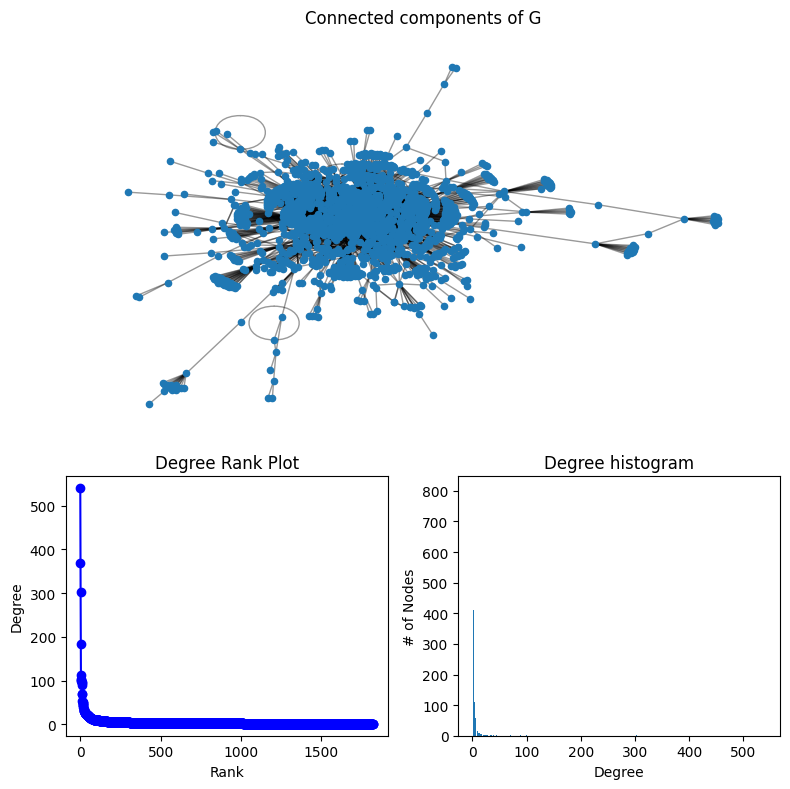

In [5]:
G = all_graphs[1]
# G = nx.gnp_random_graph(100, 0.02, seed=10374196)

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
axgrid = fig.add_gridspec(5, 4)


ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
labels = nx.get_node_attributes(Gcc, 'party')
pos = nx.spring_layout(Gcc, seed=10396953)

nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
# nx.draw_networkx_labels(Gcc, pos, ax=ax0, labels=labels)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

### Showcasing *betweenness* & *closeness* centrality score in Day 2 Graph

In [6]:
bet_cent = nx.betweenness_centrality(Gcc)
sorted_bet_cent = sorted(bet_cent.items(), key=lambda x: x[1])

clo_cent = nx.closeness_centrality(Gcc)
sorted_clo_cent = sorted(clo_cent.items(), key=lambda x: x[1])

In [7]:
top_5_bet = {}
for node in sorted_bet_cent[-5:]:
	# print('Node no.', node[0], 'and betweenness centrality score', node[1])
	# pprint(H[node[0]])
	top_5_bet[node[0]] = H[node[0]]
	top_5_bet[node[0]]['betweenness_score'] = node[1]

print('Top 5 nodes based on betweenness centrality')
df = pd.DataFrame.from_dict(top_5_bet)
df

Top 5 nodes based on betweenness centrality


,226,518,225,28,14
followers,12148,2458,15994,12594,29427
following,249,4333,294,46,671
total_tweets,12590,248797,6858,43767,5310
lists,148,3,123,155,319
twitter_age,2520,1275,767,5037,3858
verified,False,False,False,False,True
party,neutral,left,neutral,middle,right
betweenness_score,0.059733,0.0713,0.128519,0.246091,0.450701


In [8]:
top_5_cent = {}
for node in sorted_clo_cent[-5:]:
	# print('Node no.', node[0], 'and closeness centrality score', node[1])
	# pprint(H[node[0]])
	top_5_cent[node[0]] = H[node[0]]
	top_5_cent[node[0]]['closeness_score'] = node[1]

print('Top 5 nodes based on closeness centrality')
df = pd.DataFrame.from_dict(top_5_cent)
df

Top 5 nodes based on closeness centrality


,747,226,225,28,14
followers,6897,12148,15994,12594,29427
following,6863,249,294,46,671
total_tweets,106658,12590,6858,43767,5310
lists,4,148,123,155,319
twitter_age,749,2520,767,5037,3858
verified,False,False,False,False,True
party,left,neutral,neutral,middle,right
closeness_score,0.404475,0.417744,0.43685,0.456669,0.48626
betweenness_score,NaN,0.059733,0.128519,0.246091,0.450701


## Showcase Party alignment and Follower count on central nodes based on *betwenness* centrality measure

In [ ]:
bet_cent = []  # nx.betweenness_centrality(Gcc)
sorted_bet_cent = []  # sorted(bet_cent.items(), key=lambda x:x[1])
for i, G in enumerate(all_graphs[1:-1], start=1):
	# print('Day', i+1)
	Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
	bet_cent.append(nx.betweenness_centrality(Gcc))
	sorted_bet_cent.append(sorted(bet_cent[i-1].items(), key=lambda x:x[1], reverse=True))

Day 2
Node no. 14 {'party': 'right', 'followers': 29427, 'following': 671, 'total_tweets': 5310, 'lists': 319, 'twitter_age': 3858}
Node no. 28 {'party': 'middle', 'followers': 12594, 'following': 46, 'total_tweets': 43767, 'lists': 155, 'twitter_age': 5037}
Node no. 225 {'party': 'neutral', 'followers': 15994, 'following': 294, 'total_tweets': 6858, 'lists': 123, 'twitter_age': 767}
Node no. 518 {'party': 'left', 'followers': 2458, 'following': 4333, 'total_tweets': 248797, 'lists': 3, 'twitter_age': 1275}
Node no. 226 {'party': 'neutral', 'followers': 12148, 'following': 249, 'total_tweets': 12590, 'lists': 148, 'twitter_age': 2520}


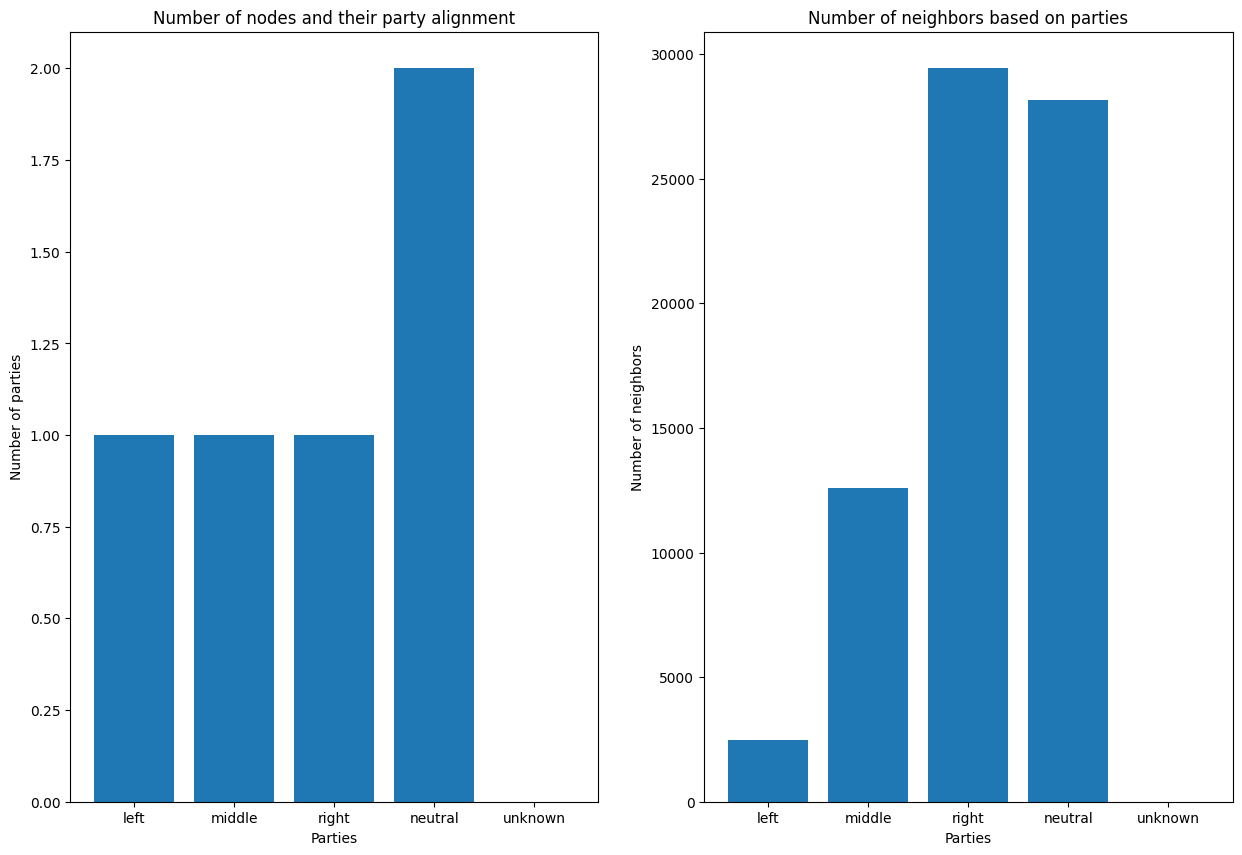

Day 3
Node no. 14 {'party': 'right', 'followers': 29427, 'following': 671, 'total_tweets': 5310, 'lists': 319, 'twitter_age': 3858}
Node no. 28 {'party': 'middle', 'followers': 12594, 'following': 46, 'total_tweets': 43767, 'lists': 155, 'twitter_age': 5037}
Node no. 54 {'party': 'left', 'followers': 519763, 'following': 3719, 'total_tweets': 157147, 'lists': 1347, 'twitter_age': 4242}
Node no. 1316 {'party': 'left', 'followers': 34597, 'following': 232, 'total_tweets': 68748, 'lists': 256, 'twitter_age': 4773}
Node no. 910 {'party': 'right', 'followers': 8988, 'following': 8722, 'total_tweets': 357459, 'lists': 22, 'twitter_age': 1294}


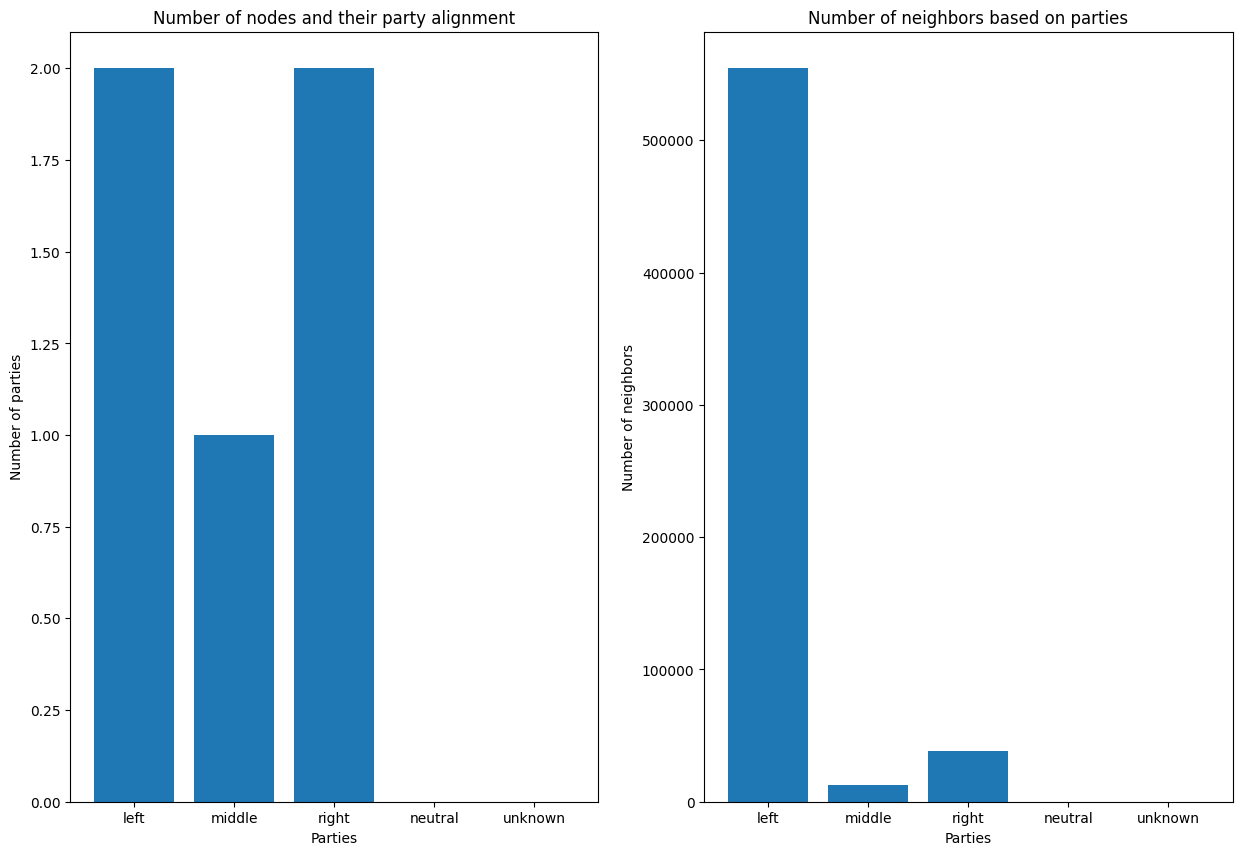

Day 4
Node no. 259 {'party': 'left', 'followers': 20012, 'following': 1240, 'total_tweets': 93787, 'lists': 116, 'twitter_age': 3519}
Node no. 225 {'party': 'neutral', 'followers': 15994, 'following': 294, 'total_tweets': 6858, 'lists': 123, 'twitter_age': 767}
Node no. 580 {'party': 'right', 'followers': 384913, 'following': 1957, 'total_tweets': 8380, 'lists': 1235, 'twitter_age': 5338}
Node no. 3028 {'party': 'left', 'followers': 20481, 'following': 455, 'total_tweets': 43531, 'lists': 132, 'twitter_age': 2926}
Node no. 1497 {'party': 'left', 'followers': 5475, 'following': 576, 'total_tweets': 31489, 'lists': 39, 'twitter_age': 4238}


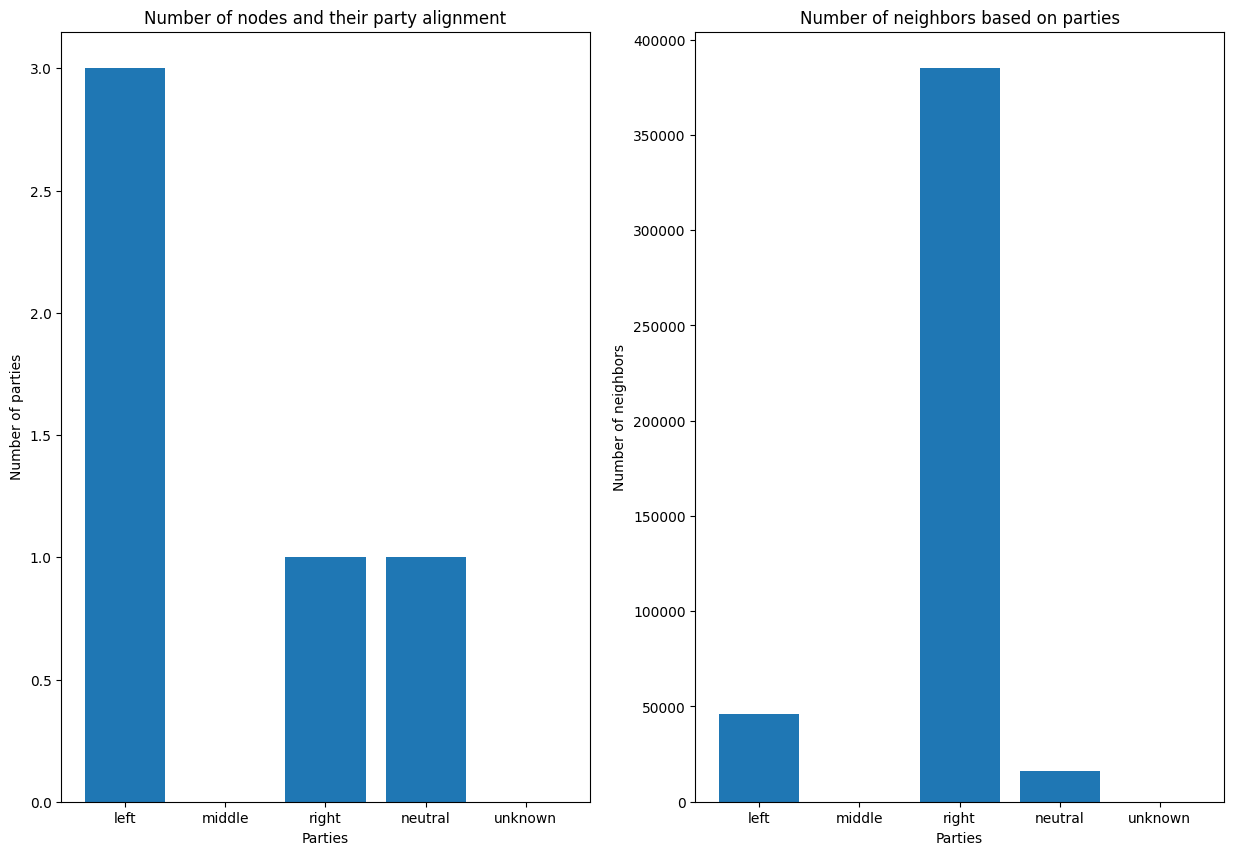

Day 5
Node no. 28 {'party': 'middle', 'followers': 12594, 'following': 46, 'total_tweets': 43767, 'lists': 155, 'twitter_age': 5037}
Node no. 43 {'party': 'left', 'followers': 19654, 'following': 1882, 'total_tweets': 18294, 'lists': 36, 'twitter_age': 475}
Node no. 71 {'party': 'right', 'followers': 33670, 'following': 2634, 'total_tweets': 143979, 'lists': 336, 'twitter_age': 2810}
Node no. 188 {'party': 'right', 'followers': 8205, 'following': 1184, 'total_tweets': 1821, 'lists': 64, 'twitter_age': 4263}
Node no. 14 {'party': 'right', 'followers': 29427, 'following': 671, 'total_tweets': 5310, 'lists': 319, 'twitter_age': 3858}


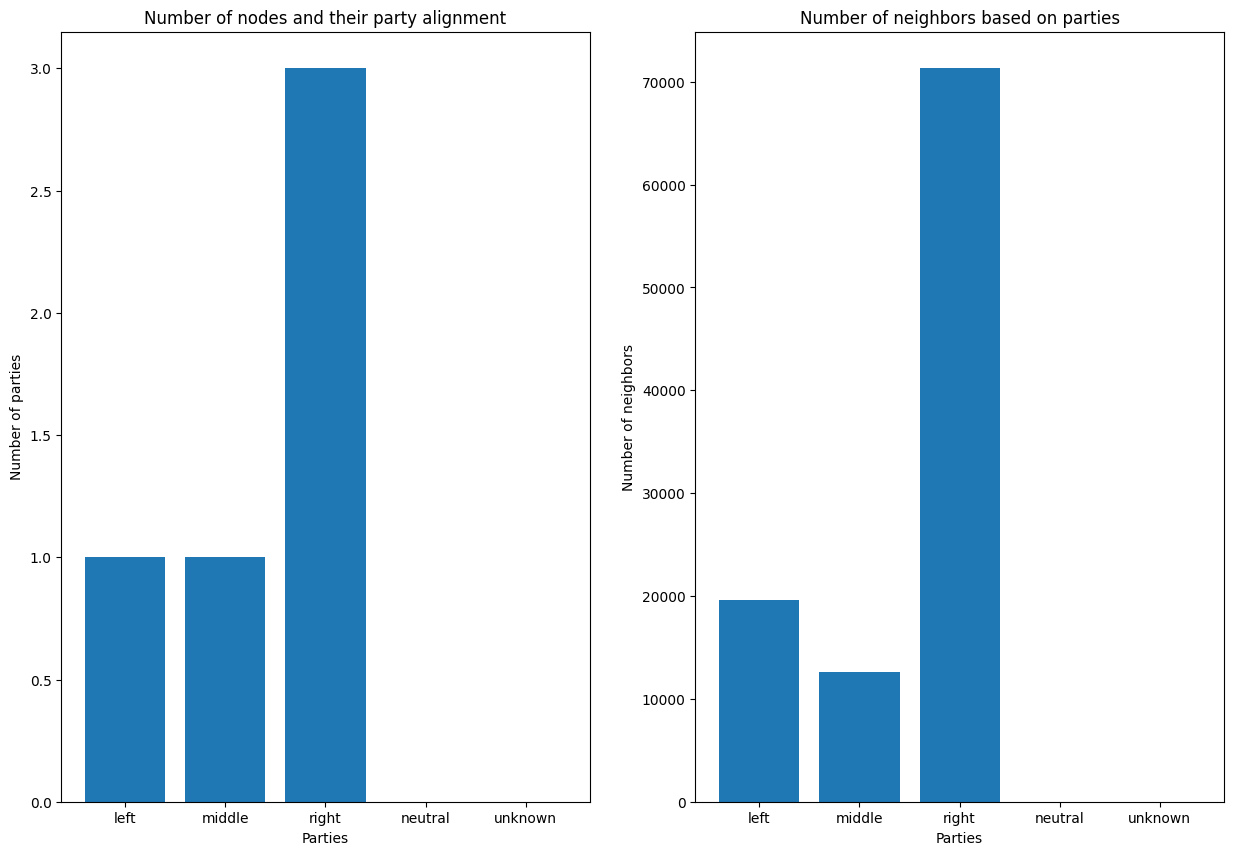

Day 6
Node no. 4522 {'party': 'right', 'followers': 30238, 'following': 134, 'total_tweets': 10591, 'lists': 122, 'twitter_age': 4172}
Node no. 28 {'party': 'middle', 'followers': 12594, 'following': 46, 'total_tweets': 43767, 'lists': 155, 'twitter_age': 5037}
Node no. 1978 {'party': 'neutral', 'followers': 348, 'following': 320, 'total_tweets': 848, 'lists': 0, 'twitter_age': 1226}
Node no. 225 {'party': 'neutral', 'followers': 15994, 'following': 294, 'total_tweets': 6858, 'lists': 123, 'twitter_age': 767}
Node no. 2289 {'party': 'left', 'followers': 2467, 'following': 1731, 'total_tweets': 55346, 'lists': 11, 'twitter_age': 485}


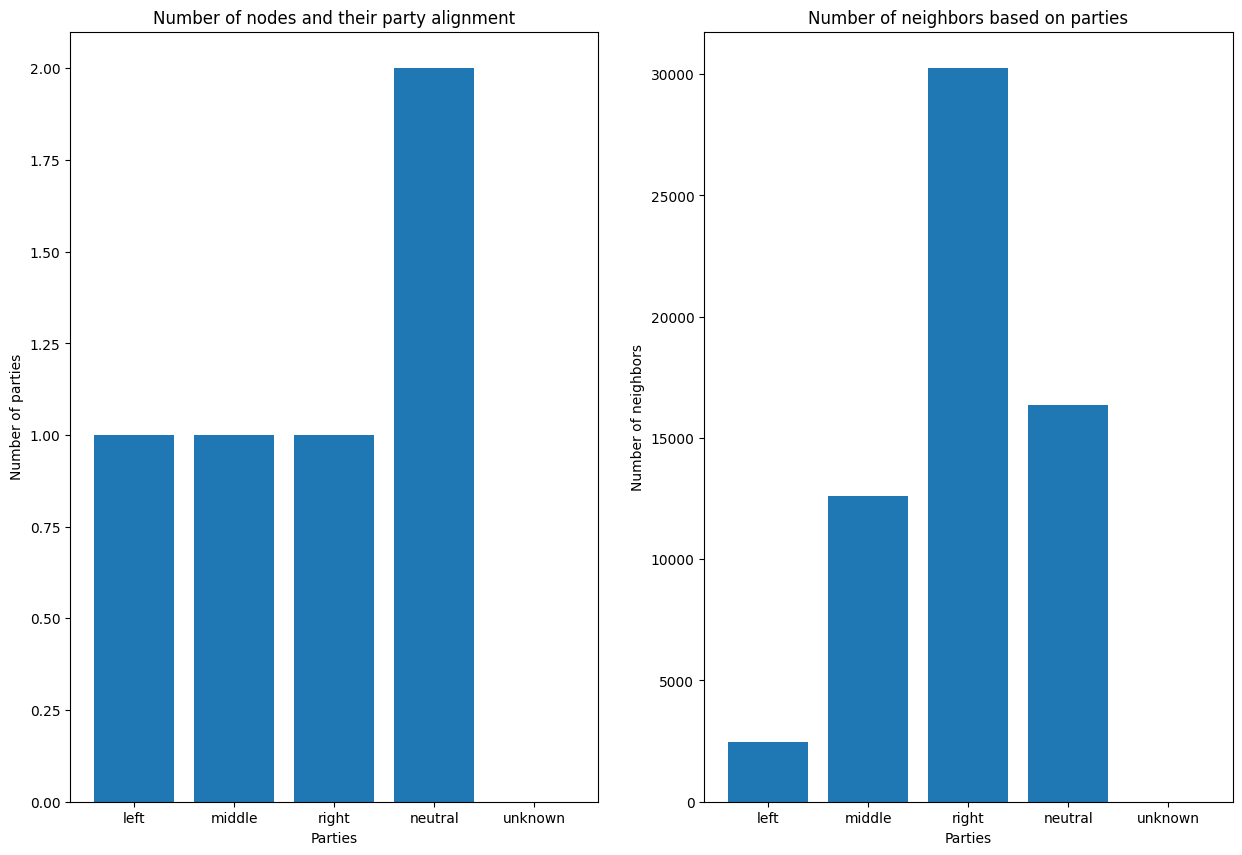

In [9]:

# endeiktika pairnoume ta prwta 6
for i, G in enumerate(all_graphs[1:6], start=1):
	print('Day', i+1)

	p = {'left':0, 'middle':0, 'right':0, 'neutral':0, 'unknown':0}
	f = {'left':0, 'middle':0, 'right':0, 'neutral':0, 'unknown':0}

	for j in sorted_bet_cent[i-1][:5]:
		print('Node no.', j[0], all_graphs[i].nodes[j[0]])
		p[all_graphs[i].nodes[j[0]]['party']] += 1
		f[all_graphs[i].nodes[j[0]]['party']] += all_graphs[i].nodes[j[0]]['followers']
	# print(p)
	# print(f)

	x = list(p.keys())
	y = np.array(list(p.values()))

	plt.subplot(1, 2, 1)
	plt.bar(x, y)
	plt.xlabel('Parties')
	plt.ylabel('Number of parties')
	plt.title('Number of nodes and their party alignment')

	y = np.array(list(f.values()))

	plt.subplot(1, 2, 2)
	plt.bar(x, y)
	plt.xlabel('Parties')
	plt.ylabel('Number of neighbors')
	plt.title('Number of neighbors based on parties')
	plt.show()

In [12]:
f = {'left': [], 'middle': [], 'right': [], 'neutral': [], 'unknown': []}
for i in range(1, 63):
	print(i)
	res = {'left': 0, 'middle': 0, 'right': 0, 'neutral': 0, 'unknown': 0}
	for j in sorted_bet_cent[i - 1][:5]:
		try:
			res[all_graphs[i].nodes[j[0]]['party']] += all_graphs[i].nodes[j[0]]['followers']
		except TypeError:
			res[all_graphs[i].nodes[j[0]]['party']] += 1
		except KeyError:
			pass
	for k in f:
		f[k].append(res[k])
plt.plot(f['left'], label='left')
plt.plot(f['right'], label='right')
plt.plot(f['neutral'], label='neutral')
plt.plot(f['middle'], label='middle')
plt.title('Neighbors of the Top-5 nodes based on betweenness centrality score')
plt.legend()
plt.show()

1
2
3
4
5
6


IndexError: list index out of range

In [ ]:
l, r, n, m, n = 0, 0, 0, 0, 0
for i in range(len(f['left'])):
	if f['left'][i] > f['right'][i] and f['left'][i] > f['middle'][i]:
		l += 1
	elif f['middle'][i] > f['left'][i] and f['middle'][i] > f['right'][i]:
		m += 1
	elif f['neutral'][i] > f['left'][i] and f['neutral'][i] > f['right'][i] and f['neutral'][i] > f['middle'][i]:
		n += 1
	else:
		r += 1
l, r, m, n

## Showcase Party alignment and Follower count on central nodes based on *closeness* centrality measure

In [ ]:
clo_cent = []  # nx.betweenness_centrality(Gcc)
sorted_clo_cent = []  # sorted(bet_cent.items(), key=lambda x:x[1])
for i, G in enumerate(all_graphs[1:-1], start=1):
	# print('Day', i+1)
	Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
	clo_cent.append(nx.closeness_centrality(Gcc))
	sorted_clo_cent.append(sorted(clo_cent[i-1].items(), key=lambda x:x[1], reverse=True))

In [ ]:

# endeiktika pairnoume ta prwta 6
for i, G in enumerate(all_graphs[1:6], start=1):
	print('Day', i+1)

	p = {'left':0, 'middle':0, 'right':0, 'neutral':0, 'unknown':0}
	f = {'left':0, 'middle':0, 'right':0, 'neutral':0, 'unknown':0}

	for j in sorted_clo_cent[i-1][:5]:
		print('Node no.', j[0], all_graphs[i].nodes[j[0]])
		p[all_graphs[i].nodes[j[0]]['party']] += 1
		f[all_graphs[i].nodes[j[0]]['party']] += all_graphs[i].nodes[j[0]]['followers']
	# print(p)
	# print(f)

	x = list(p.keys())
	y = np.array(list(p.values()))

	plt.subplot(1, 2, 1)
	plt.bar(x, y)
	plt.xlabel('Parties')
	plt.ylabel('Number of parties')
	plt.title('Number of nodes and their party alignment')

	y = np.array(list(f.values()))

	plt.subplot(1, 2, 2)
	plt.bar(x, y)
	plt.xlabel('Parties')
	plt.ylabel('Number of neighbors')
	plt.title('Number of neighbors based on parties')
	plt.show()

In [ ]:
f = {'left': [], 'middle': [], 'right': [], 'neutral': [], 'unknown': []}
for i in range(1, 63):
	res = {'left': 0, 'middle': 0, 'right': 0, 'neutral': 0, 'unknown': 0}
	for j in sorted_clo_cent[i - 1][:5]:
		try:
			res[all_graphs[i].nodes[j[0]]['party']] += all_graphs[i].nodes[j[0]]['followers']
		except TypeError:
			res[all_graphs[i].nodes[j[0]]['party']] += 1
	for k in f:
		f[k].append(res[k])
plt.plot(f['left'], label='left')
plt.plot(f['right'], label='right')
plt.plot(f['neutral'], label='neutral')
plt.plot(f['middle'], label='middle')
plt.title('Neighbors of the Top-5 nodes based on closeness centrality score')
plt.legend()
plt.show()

In [ ]:
l, r, n, m, n = 0, 0, 0, 0, 0
for i in range(len(f['left'])):
	if f['left'][i] > f['right'][i] and f['left'][i] > f['middle'][i]:
		l += 1
	elif f['middle'][i] > f['left'][i] and f['middle'][i] > f['right'][i]:
		m += 1
	elif f['neutral'][i] > f['left'][i] and f['neutral'][i] > f['right'][i] and f['neutral'][i] > f['middle'][i]:
		n += 1
	else:
		r += 1
l, r, m, n